## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
PATH = '../data/planet/'

In [5]:
ls {PATH}

models/                       test-jpg.tar.7z               train-jpg.tar
sample_submission_v2.csv      test-tif-v2.tar.7z            train-jpg.tar.7z
sample_submission_v2.csv.zip  test_v2_file_mapping.csv      train-tif-v2.tar.7z
test-jpg/                     test_v2_file_mapping.csv.zip  train_v2.csv
test-jpg-additional.tar.7z    tmp/
test-jpg.tar                  train-jpg/


In [6]:
!ls {PATH}train-jpg/ | wc -l
!ls {PATH}test-jpg/ | wc -l


40479
40669


## Multi-label versus single-label classification

In [7]:
from fastai.plots import *

In [8]:
def get_1st(path): return glob(f'{path}/*.*')[0]

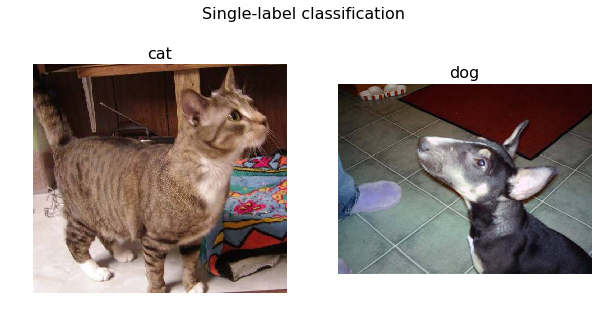

In [9]:
dc_path = "../data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

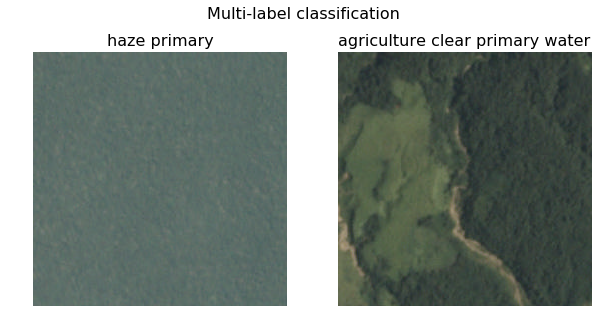

In [10]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [11]:
from helper.planet import f2

metrics=[f2]
f_model = resnet34

In [12]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [13]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [14]:
data = get_data(256)
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [15]:
x,y = next(iter(data.val_dl))

In [16]:
x.shape

torch.Size([64, 3, 256, 256])

In [17]:
y.shape

torch.Size([64, 17])

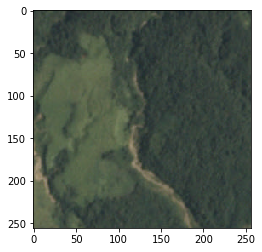

In [18]:
sample = to_np(x[0])
sample_denorm = data.val_ds.denorm(sample)[0]
plt.imshow(sample_denorm)

In [19]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


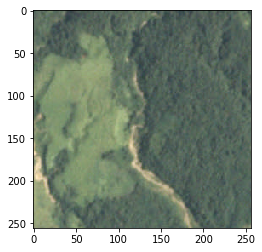

In [20]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.5);

___

## Begin Training with 64 x 64

### Generate Data

In [21]:
sz=64

In [22]:
data = get_data(sz)

In [23]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [24]:
x,y = next(iter(data.trn_dl))
x.shape, y.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 17]))

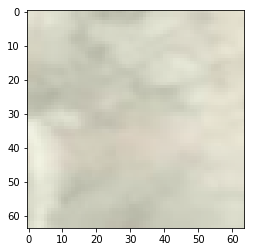

In [27]:
sample = to_np(x[0])
plt.imshow(data.val_ds.denorm(sample)[0]*1.2)

In [28]:
metrics

[<function helper.planet.f2>]

### Find Optimal Learning Rate

In [29]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.216037   0.315092   0.809903  



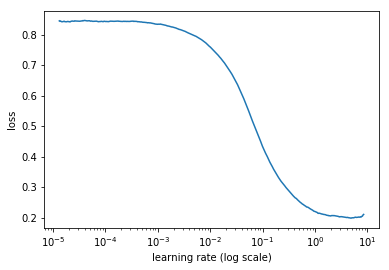

In [30]:
lrf=learn.lr_find()
learn.sched.plot()

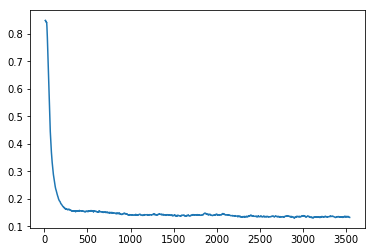

In [34]:
learn.sched.plot_loss()

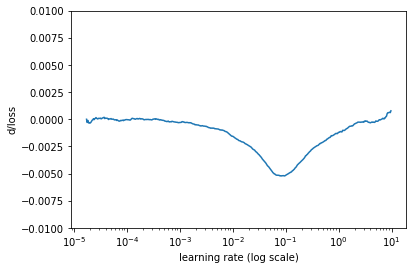

In [31]:
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.sched.lrs)):
        derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)

plot_loss_change(learn.sched, sma=20)

**Looking at the above plot, we can see that 0.1 seems the best learning rate.**

### Traing with optimal learning rate

In [32]:
lr = 0.1

In [33]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.154818   0.140602   0.874667  
    1      0.142347   0.132039   0.883831  
    2      0.140347   0.130577   0.885494  
    3      0.141909   0.128204   0.887142  
    4      0.135472   0.12639    0.889206  
    5      0.134682   0.125102   0.89124   
    6      0.132774   0.125129   0.890975  



[0.12512928, 0.890974719616627]

### Unfreeze and Train with differential learning rate

In [36]:
lrs = np.array([lr/9,lr/3,lr])

In [37]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.12412    0.112235   0.904773  
    1      0.117617   0.105519   0.910002  
    2      0.108307   0.10271    0.914004  
    3      0.110404   0.10368    0.91313   
    4      0.10451    0.100585   0.916347  
    5      0.102682   0.098442   0.917879  
    6      0.09966    0.098135   0.917769  



[0.09813463, 0.9177689172560882]

In [38]:
learn.save(f'{sz}')

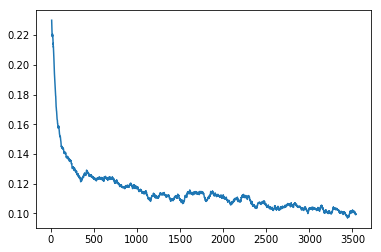

In [39]:
learn.sched.plot_loss()

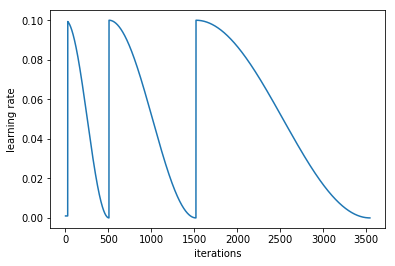

In [41]:
learn.sched.plot_lr()

## Begin Training with 128 x 128

### Generate dataset

In [42]:
sz=128

### Freeze for Transfer Learning

In [44]:
learn.set_data(get_data(sz))
learn.freeze()

In [45]:
learn.fit(lr, n_cycle=3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.101452   0.09886    0.915397  
    1      0.099903   0.096911   0.917985  
    2      0.096782   0.096286   0.91851   
    3      0.097542   0.096054   0.918257  
    4      0.097488   0.094971   0.920146  
    5      0.095708   0.094511   0.91941   
    6      0.099623   0.095227   0.918402  



[0.09522722, 0.9184023558173557]

**F2 Score not improving**

### Unfreeze and train with differential learning rate

In [46]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2         
    0      0.096595   0.09061    0.923028  
    1      0.094363   0.087846   0.92645   
    2      0.091819   0.087786   0.926489  
    3      0.093368   0.08822    0.925946  
    4      0.090658   0.087589   0.92582   
    5      0.087838   0.085658   0.92838   
    6      0.088172   0.085712   0.928322  



___

**TODO**

In [ ]:
sz=256

In [24]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09161  0.08651  0.92712]                         
[ 1.       0.08933  0.08665  0.92677]                         
[ 2.       0.09125  0.08584  0.92719]                         
[ 3.       0.08732  0.08532  0.92812]                         
[ 4.       0.08736  0.08479  0.92854]                         
[ 5.       0.08807  0.08471  0.92835]                         
[ 6.       0.08942  0.08448  0.9289 ]                         



In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08932  0.08218  0.9324 ]                         
[ 1.       0.08654  0.08195  0.93313]                         
[ 2.       0.08468  0.08024  0.93391]                         
[ 3.       0.08596  0.08141  0.93287]                         
[ 4.       0.08211  0.08152  0.93401]                         
[ 5.       0.07971  0.08001  0.93377]                         
[ 6.       0.07928  0.0792   0.93554]                         



____

In [47]:
learn.models_path

'../data/planet/tmp/83/models'

In [48]:
learn.load(f'{sz}')

In [49]:
multi_preds, y = learn.TTA()

In [50]:
multi_preds.shape, y.shape

((5, 8095, 17), (8095, 17))

In [51]:
multi_preds[:,0,:]

array([[0.88809, 0.00072, 0.00942, 0.00053, 0.00035, 0.99811, 0.00009, 0.00016, 0.4024 , 0.13924, 0.00069,
        0.00072, 0.99915, 0.45964, 0.00175, 0.01094, 0.82816],
       [0.72347, 0.00817, 0.01684, 0.00039, 0.0006 , 0.99962, 0.00004, 0.00026, 0.24032, 0.12875, 0.00014,
        0.00043, 0.9996 , 0.32473, 0.00119, 0.00533, 0.93229],
       [0.85917, 0.00113, 0.01112, 0.00043, 0.00029, 0.99843, 0.00005, 0.00014, 0.33217, 0.09501, 0.00037,
        0.00101, 0.99947, 0.33059, 0.001  , 0.0068 , 0.90581],
       [0.78233, 0.00217, 0.01419, 0.00083, 0.00083, 0.99795, 0.0001 , 0.0002 , 0.35996, 0.04778, 0.00094,
        0.00069, 0.99952, 0.29277, 0.00239, 0.00702, 0.80485],
       [0.71257, 0.00139, 0.00957, 0.00061, 0.00075, 0.99961, 0.00003, 0.00015, 0.21414, 0.04573, 0.00015,
        0.00033, 0.99973, 0.27585, 0.00179, 0.00465, 0.86211]], dtype=float32)

In [52]:
y[0,:]

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32)

In [54]:
preds = np.mean(multi_preds, 0)
preds[0,:]

array([0.79313, 0.00272, 0.01223, 0.00056, 0.00056, 0.99875, 0.00006, 0.00018, 0.3098 , 0.0913 , 0.00046,
       0.00063, 0.99949, 0.33672, 0.00162, 0.00695, 0.86664], dtype=float32)

**Sample Predictions**

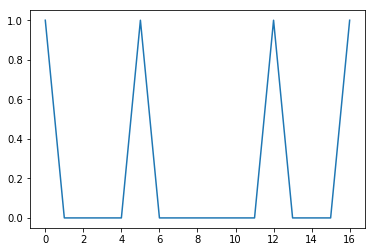

In [55]:
plt.plot(y[0,:])

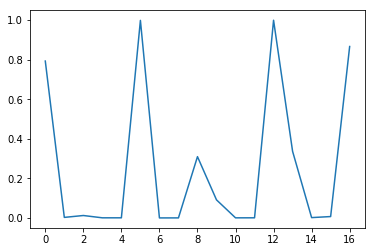

In [56]:
plt.plot(preds[0,:])

In [57]:
f2(preds,y)

0.9284681404447971

### End